### WHC _and_ CSR Validation
Swap names, checkpoints in and out, change Plot file names

In [18]:
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter 
import scipy
import json
import torchvision.transforms.functional as F
from matplotlib import cm as CM
from image import *
from model import CSRNet
from WHCmodel import WHCNet
# Because the WHC model is almost identical, running them in the same folder requires renaming the model file.
# Also: in the WHC model file it was still called CSRNet, so that was changed
import torch
%matplotlib inline

C:\Users\calci\AppData\Local\Temp\ipykernel_23384\1706322840.py:10: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


In [19]:
# ImageNet mean and std
from torchvision import datasets, transforms
transform=transforms.Compose([
                       transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225]),
                   ])

In [20]:
#now generate the ShanghaiA's ground truth
#part_A_train = os.path.join(root,'part_A_final/train_data','images')
part_A_test = r'YOUR_VALIDATION_DATA_PATH'
#part_B_train = os.path.join(root,'part_B_final/train_data','images')
#part_B_test = os.path.join(root,'part_B_final/test_data','images')
path_sets = [part_A_test] # I'm only using one but left this as is

In [21]:
# File paths for any png
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.png')):
        img_paths.append(img_path)

In [22]:
# CUDA 12, 4060 TI used for all work
#modelC = CSRNet().cuda()
modelW = WHCNet().cuda()

d:\PROGRAM\Miniconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\PROGRAM\Miniconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
#CSRcheckpoint = torch.load('0model_best.pth.tar') #CSRNet 1
#CSRcheckpoint2 = torch.load('0model_best_NOV.pth.tar') #CSRNet 1.5?
#checkpoint = torch.load('0checkpoint.pth.tar') #CSRNet 2 - this is awful
WHCcheckpoint = torch.load('default_taskmodel_best.pth.tar') #WHCNet

C:\Users\calci\AppData\Local\Temp\ipykernel_23384\1055303699.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  WHCcheckpoint = torch.load('default_taskmodel_best.pth.tar')

In [7]:
#modelC.load_state_dict(CSRcheckpoint['state_dict'])

<All keys matched successfully>

In [24]:
modelW.load_state_dict(WHCcheckpoint['state_dict'])

<All keys matched successfully>

In [ ]:
to_tensor = ToTensor() # Wonder function that takes basically anything and makes it a tensor

In [ ]:
# Adapted WHCNet version, the one in the repo didnt work.
# But..
# This is not MAE because it isn't comparing against the ground truth.
mae = 0.0

for i in range(len(img_paths)):
    img = transform(Image.open(img_paths[i]).convert('RGB')).cuda()
    output = modelC(img.unsqueeze(0))
    
    pred_value = output.detach().cpu().sum().item()
    
    mae += pred_value
    
    print('predict:', pred_value)

print(mae / len(img_paths))

predict: 3.1690101623535156
predict: 3.1525397300720215
predict: 3.1946542263031006
predict: 3.1908748149871826
predict: 3.1606521606445312
predict: 3.1970314979553223
predict: 3.176265001296997
predict: 3.170661211013794
predict: 3.170363426208496
predict: 3.1603968143463135
predict: 3.1763558387756348
predict: 3.188866376876831
predict: 3.163217067718506
predict: 3.1592135429382324
predict: 3.1549386978149414
predict: 3.138216495513916
predict: 3.1970391273498535
predict: 3.134721040725708
predict: 3.1532468795776367
predict: 3.168705701828003
predict: 3.172952651977539
predict: 3.172646999359131
predict: 3.154618263244629
predict: 3.2068872451782227
predict: 3.191509485244751
predict: 3.171584367752075
predict: 3.1922061443328857
predict: 3.1572885513305664
predict: 3.1406736373901367
predict: 3.1401124000549316
predict: 3.1599631309509277
predict: 3.153456687927246
predict: 3.1545190811157227
predict: 3.210528612136841
predict: 3.1532866954803467
predict: 3.1777381896972656
predict

In [ ]:
# MAE for WHCNet
# 3.75
mae = 0
for i in range(len(img_paths)):
    img = 255.0 * F.to_tensor(Image.open(img_paths[i]).convert('RGB')) # Make ita PyTorch tensor, RGB, scale tensor range 0-255
    # These means are taken from dataset.py
    img[0,:,:]=img[0,:,:]-92.8207477031
    img[1,:,:]=img[1,:,:]-95.2757037428
    img[2,:,:]=img[2,:,:]-104.877445883

    img = img.cuda()
    img = transform(Image.open(img_paths[i]).convert('RGB')).cuda()
    gt_file = h5py.File(img_paths[i].replace('.png','.h5').replace('images','ground_truth'),'r')
    groundtruth = np.asarray(gt_file['density'])
    output = modelW(img.unsqueeze(0)) # Adds batch dimension at start
    mae += abs(output.detach().cpu().sum().numpy()-np.sum(groundtruth)) # Sum of tensor minus ground truth, on CPU because GPU is output.
    print(i,mae)
print(mae/len(img_paths))

0 4.7644467
1 8.248579
2 12.918068
3 14.288165
4 18.170095
5 20.663784
6 25.66825
7 31.554674
8 33.914886
9 35.784027
10 36.510365
11 39.551823
12 42.644154
13 42.773197
14 47.121357
15 49.704247
16 52.683777
17 56.291245
18 59.59265
19 65.14706
20 67.69354
21 70.9348
22 78.78895
23 87.80377
24 93.20202
25 93.9475
26 98.6198
27 102.82495
28 107.760475
29 110.11572
30 115.23416
31 116.344185
32 116.41269
33 119.42078
34 127.76997
35 130.11368
36 139.04729
37 144.82147
38 150.65732
39 150.86298
40 154.75078
41 155.16371
42 157.89322
43 160.45229
44 165.96527
45 174.89714
46 176.89069
47 183.2052
48 183.82988
49 185.91422
50 189.40797
51 196.41476
52 199.80438
53 202.31177
54 203.73175
55 204.35786
56 205.54543
57 206.12828
58 207.91658
59 208.56702
60 210.87904
61 217.30235
62 221.30452
63 227.8401
64 228.26805
65 229.45897
66 231.45741
67 241.69115
68 242.33752
69 244.73898
70 247.13545
71 248.06146
72 252.44461
73 255.7319
74 257.7971
75 257.94052
76 260.4343
77 262.3483
78 263.1819
79

(read on for why), MAE visualised:

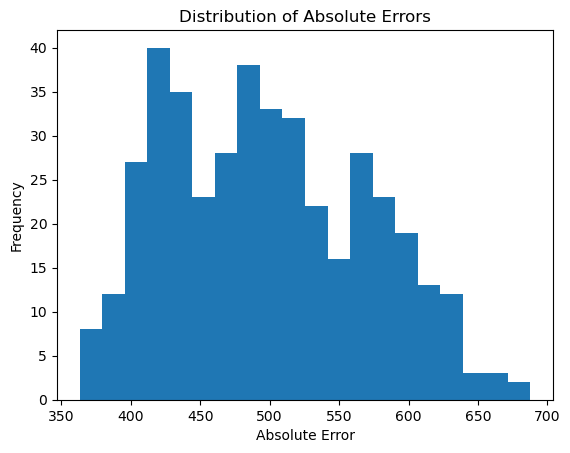

In [25]:
abs_errors = []

for img_path in img_paths:
    img = 255.0 * to_tensor(Image.open(img_path).convert('RGB'))
    img[0, :, :] -= 92.8207477031
    img[1, :, :] -= 95.2757037428
    img[2, :, :] -= 104.877445883
    img = img.cuda()

    gt_file_path = img_path.replace('.png', '.h5').replace('images', 'ground_truth')
    with h5py.File(gt_file_path, 'r') as gt_file:
        groundtruth_count = np.sum(gt_file['density'][:])

    output = modelW(img.unsqueeze(0))
    predicted_count = output.detach().cpu().sum().item()

    abs_error = abs(predicted_count - groundtruth_count)
    abs_errors.append(abs_error)

# Absolute error
plt.hist(abs_errors, bins = 20)
plt.xlabel("Absolute Error")
plt.ylabel("Frequency")
plt.title("Distribution of Absolute Errors")
plt.savefig("WHC_abs_err_dist.png", dpi = 300, bbox_inches = "tight")
plt.show()

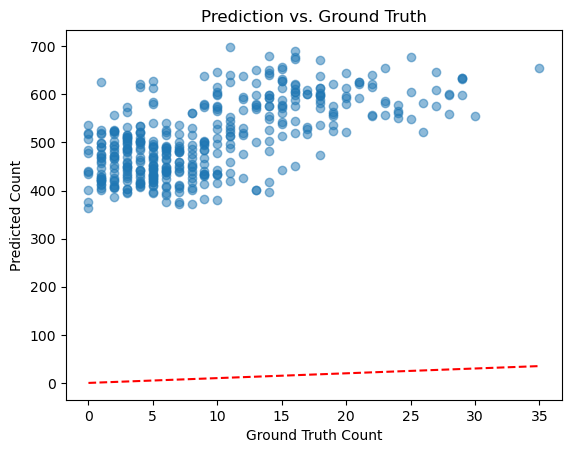

In [26]:
predicted_counts = []
groundtruth_counts = []

for img_path in img_paths:
    img = 255.0 * to_tensor(Image.open(img_path).convert('RGB'))
    img[0, :, :] -= 92.8207477031
    img[1, :, :] -= 95.2757037428
    img[2, :, :] -= 104.877445883
    img = img.cuda()

    gt_file_path = img_path.replace('.png', '.h5').replace('images', 'ground_truth')
    with h5py.File(gt_file_path, 'r') as gt_file:
        groundtruth_count = np.sum(gt_file['density'][:])
        groundtruth_counts.append(groundtruth_count)

    output = modelW(img.unsqueeze(0))
    predicted_count = output.detach().cpu().sum().item()
    predicted_counts.append(predicted_count)

plt.scatter(groundtruth_counts, predicted_counts, alpha = 0.5)
plt.plot([0, max(groundtruth_counts)], [0, max(groundtruth_counts)], 'r--') # The ground truth line
plt.xlabel("Ground Truth Count")
plt.ylabel("Predicted Count")
plt.title("Prediction vs. Ground Truth")
plt.savefig("WHC_pred_count_scatter.png", dpi = 300, bbox_inches = "tight")
plt.show()

In [27]:
# RMSE
mse = 0.0
for i in range(len(img_paths)):
    img = 255.0 * F.to_tensor(Image.open(img_paths[i]).convert('RGB'))
    img[0, :, :] = img[0, :, :] - 92.8207477031
    img[1, :, :] = img[1, :, :] - 95.2757037428
    img[2, :, :] = img[2, :, :] - 104.877445883

    img = img.cuda()
    gt_file = h5py.File(
        img_paths[i].replace('.png', '.h5').replace('images', 'ground_truth'),
        'r'
        )
    groundtruth = np.asarray(gt_file['density'])
    output = modelW(img.unsqueeze(0))
    mse += (output.detach().cpu().sum().item() - np.sum(groundtruth)) ** 2
    print(i, np.sqrt(mse / (i + 1)))

mse_t = mse / len(img_paths)
print(f'MSE: {mse_t}')
rmse = np.sqrt(mse_t)
print(f'RMSE: {rmse}')

0 507.21844
1 474.0132
2 463.39703
3 461.26672
4 453.49445
5 457.25214
6 458.96268
7 466.99658
8 461.1143
9 462.93784
10 464.04254
11 463.33963
12 460.59534
13 464.20038
14 465.50867
15 464.34656
16 465.4344
17 463.42996
18 467.59338
19 469.16272
20 471.60138
21 471.78262
22 468.45734
23 465.96033
24 464.74484
25 462.61874
26 465.27887
27 465.97
28 467.11774
29 468.89282
30 467.35837
31 465.52002
32 466.47632
33 464.89474
34 466.00912
35 464.43155
36 462.42896
37 461.02063
38 461.0939
39 462.029
40 461.19254
41 459.9687
42 460.58212
43 461.49994
44 460.69153
45 461.5317
46 461.24866
47 460.48157
48 459.7402
49 459.49326
50 459.54385
51 460.39917
52 460.53278
53 461.18643
54 460.40735
55 458.94717
56 457.74118
57 457.19653
58 457.6635
59 458.00674
60 458.50854
61 458.94595
62 460.64694
63 461.36334
64 461.64432
65 462.10553
66 462.4246
67 462.03302
68 461.76477
69 461.4815
70 461.71902
71 460.52643
72 460.7067
73 460.05682
74 460.8945
75 460.6595
76 459.95706
77 460.72803
78 460.02795
7

### RMSE and MAE results

Comparted to MAE, RMSE is huge. It penalises outliers more severely than MAE, but this number is very high. Further invesigation below.

Image 0: Predicted Count = 507.21844482421875, Ground Truth = 0.0, Error = 507.21844482421875
Image 1: Predicted Count = 438.2995910644531, Ground Truth = 0.0, Error = 438.2995910644531
Image 2: Predicted Count = 441.3992919921875, Ground Truth = 0.0, Error = 441.3992919921875
Image 3: Predicted Count = 457.8160400390625, Ground Truth = 2.999999761581421, Error = 454.8160400390625
Image 4: Predicted Count = 422.9727783203125, Ground Truth = 2.0, Error = 420.9727783203125
Image 5: Predicted Count = 476.5954895019531, Ground Truth = 0.9999999403953552, Error = 475.5954895019531
Image 6: Predicted Count = 470.0948791503906, Ground Truth = 1.0, Error = 469.0948791503906
Image 7: Predicted Count = 519.7684936523438, Ground Truth = 0.0, Error = 519.7684936523438
Image 8: Predicted Count = 415.03668212890625, Ground Truth = 4.0, Error = 411.03668212890625
Image 9: Predicted Count = 481.0375671386719, Ground Truth = 1.9999998807907104, Error = 479.0375671386719
Image 10: Predicted Count = 479.

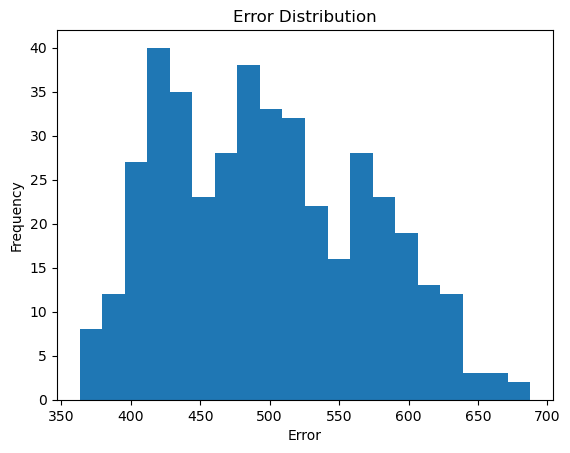

In [28]:
errors = []

for i in range(len(img_paths)):
    img = 255.0 * to_tensor(Image.open(img_paths[i]).convert('RGB'))
    img[0, :, :] -= 92.8207477031
    img[1, :, :] -= 95.2757037428
    img[2, :, :] -= 104.877445883
    img = img.cuda()

    gt_file_path = img_paths[i].replace('.png', '.h5').replace('images', 'ground_truth')
    with h5py.File(gt_file_path, 'r') as gt_file:
        groundtruth_count = np.sum(gt_file['density'][:]) 

    output = modelW(img.unsqueeze(0))
    predicted_count = output.detach().cpu().sum().item()

    error = predicted_count - groundtruth_count
    errors.append(error)

    print(f"Image {i}: Predicted Count = {predicted_count}, Ground Truth = {groundtruth_count}, Error = {error}")

plt.hist(errors, bins = 20)
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Error Distribution')
plt.savefig("WHC_RMSE_abs_err_dist.png", dpi = 300, bbox_inches = "tight")
plt.show()

``` Image 19: Predicted Count = 499.0415954589844, Ground Truth = 1.0, Error = 498.0415954589844 ```

I have no means (that I'm aware of) of viewing ```.h5``` files, so below we will try to view the heatmap ground truth and the heatmap generated.

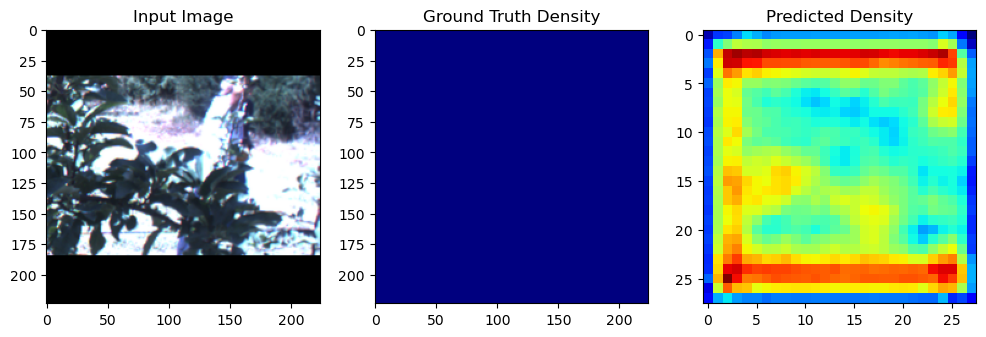

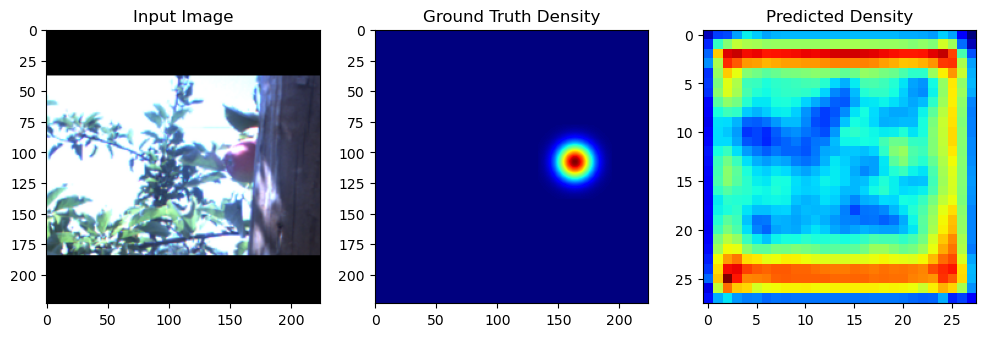

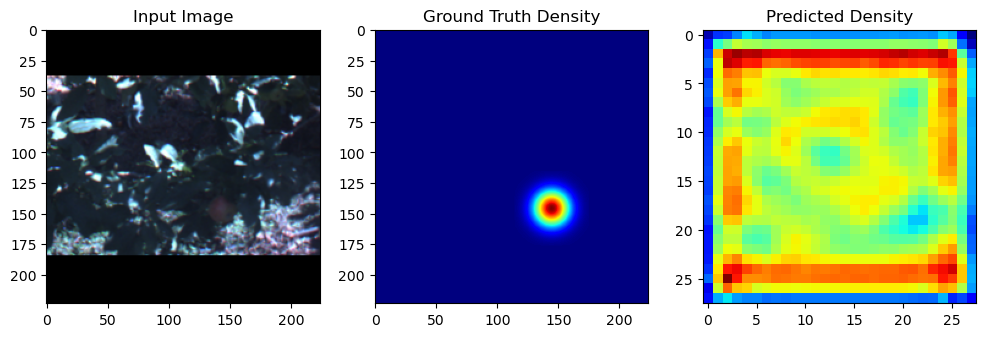

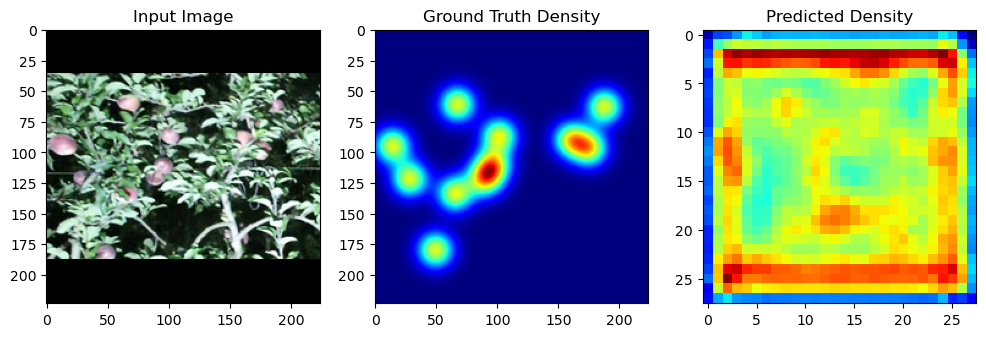

In [29]:
for img_idx in [0, 5, 17, 413]:  # Random numbers from data set
    img_path = img_paths[img_idx]
    img = Image.open(img_path)
    
    with h5py.File(img_path.replace('.png', '.h5').replace('images', 'ground_truth'), 'r') as gt_file:
        groundtruth_density = gt_file['density'][:]
    predicted_density = modelW(to_tensor(img).unsqueeze(0).cuda()).detach().cpu().squeeze().numpy()

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    axes[0].imshow(img)
    axes[0].set_title("Input Image")
    axes[1].imshow(groundtruth_density, cmap = 'jet')
    axes[1].set_title("Ground Truth Density")
    axes[2].imshow(predicted_density, cmap = 'jet')
    axes[2].set_title("Predicted Density")
    plt.savefig("WHC_GT_PD.png", dpi = 300, bbox_inches = "tight") # Only saves the last one
    plt.show()
